In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import cross_validation
import seaborn as sns
import xgboost as xgb

## Get the data

In [183]:
# dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
train = pd.read_csv('data/train.csv', low_memory=False, parse_dates = ['Date'])
test = pd.read_csv('data/test.csv', low_memory=False, parse_dates = ['Date'])
stores = pd.read_csv('data/store.csv', low_memory=False)

In [184]:
print train.isnull().sum(axis=0)
print test.isnull().sum(axis=0)
print stores.isnull().sum(axis=0)

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


## Researches 

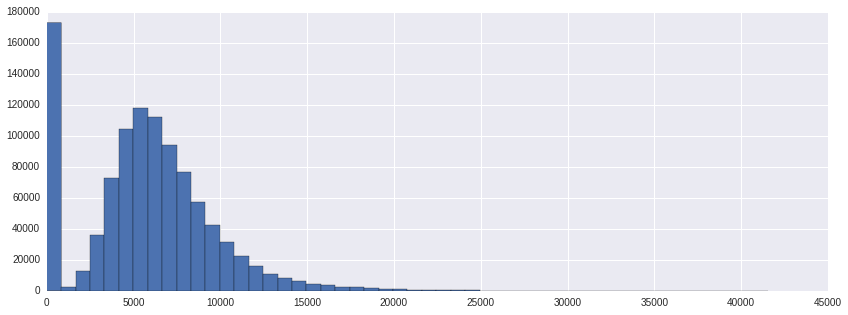

In [185]:
train.Sales.hist(bins=50, figsize=(14, 5))

In [186]:
# Percentage of zero Sales -- 17%  !!!
(train.Sales == 0).mean()

0.16994639253093513

## Prepare the data

In [187]:
test.fillna(1, inplace=True)
# train = train.loc[train["Open"] != 0]

In [188]:
# merge datasets with Stores data
train = pd.merge(train, stores, on='Store')
test = pd.merge(test, stores, on='Store')

### 1. Feature engineering

In [189]:
def build_features(data):
    data.fillna(0, inplace=True)
    # data.loc[data.Open.isnull(), 'Open'] = 1
    
    dates = pd.DatetimeIndex(data.Date)
    data['Day'] = data.Date.apply(lambda x: x.day)
    data['Month'] = data.Date.apply(lambda x: x.month)
    data['Year'] = data.Date.apply(lambda x: x.year)
    data['DayOfYear'] = data.Date.map(lambda x: x.dayofyear)
    data['WeekOfYear'] = data.Date.apply(lambda x: x.weekofyear)
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)

    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / float(4)
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    data['p_1'] = data.PromoInterval.apply(lambda x: x[:3] if type(x) == str else 0)
    data['p_2'] = data.PromoInterval.apply(lambda x: x[4:7] if type(x) == str else 0)
    data['p_3'] = data.PromoInterval.apply(lambda x: x[8:11] if type(x) == str else 0)
    data['p_4'] = data.PromoInterval.apply(lambda x: x[12:15] if type(x) == str else 0)
    
    data['Promo_Jan'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "Jan" in x else 0)
    data['Promo_Feb'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "Feb" in x else 0)
    data['Promo_Mar'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "Mar" in x else 0)
    data['Promo_Apr'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "Apr" in x else 0)
    data['Promo_May'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "May" in x else 0)
    data['Promo_Jun'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "Jun" in x else 0)
    data['Promo_Jul'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "Jul" in x else 0)
    data['Promo_Aug'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "Aug" in x else 0)
    data['Promo_Sep'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "Sep" in x else 0)
    data['Promo_Oct'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "Oct" in x else 0)
    data['Promo_Nov'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "Nov" in x else 0)
    data['Promo_Dec'] = data.PromoInterval.apply(lambda x: 1 if type(x) == str and "Dec" in x else 0)
    
    data['Distance_1'] = data.CompetitionDistance.apply(lambda x: 1 if x < 1000 else 0)
    data['Distance_2'] = data.CompetitionDistance.apply(lambda x: 1 if x >= 1000 and x < 3000 else 0)
    data['Distance_3'] = data.CompetitionDistance.apply(lambda x: 1 if x >= 3000 and x < 5000 else 0)
    data['Distance_4'] = data.CompetitionDistance.apply(lambda x: 1 if x >= 5000 and x < 10000 else 0)
    data['Distance_5'] = data.CompetitionDistance.apply(lambda x: 1 if x >= 10000 and x < 25000 else 0)
    data['Distance_6'] = data.CompetitionDistance.apply(lambda x: 1 if x >= 25000 else 0)

In [190]:
%%time
build_features(train)
build_features(test)

CPU times: user 1min 44s, sys: 2.32 s, total: 1min 46s
Wall time: 1min 43s


In [191]:
%%time
train = pd.get_dummies(train, columns=['StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment'])
test = pd.get_dummies(test, columns=['StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment'])

CPU times: user 1.83 s, sys: 1.75 s, total: 3.58 s
Wall time: 5.2 s


In [192]:
test.insert(test.columns.get_loc("StateHoliday_a") + 1, "StateHoliday_b", 0)
test.insert(test.columns.get_loc("StateHoliday_b") + 1, "StateHoliday_c", 0)

In [193]:
# Replace labels with floats
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

for c in ['p_1', 'p_2', 'p_3', 'p_4']:
    train[c] = lbl_enc.fit_transform(train[c])
    test[c] = lbl_enc.transform(test[c])

In [194]:
# Choose columns
features = list(train.columns)
[features.remove(c) for c in ['Sales', 'Date', 'Customers', 'PromoInterval', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Promo2SinceWeek']]
print "Features: "
print features

Features: 
['Store', 'DayOfWeek', 'Open', 'Promo', 'CompetitionDistance', 'Promo2', 'Day', 'Month', 'Year', 'DayOfYear', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'p_1', 'p_2', 'p_3', 'p_4', 'Promo_Jan', 'Promo_Feb', 'Promo_Mar', 'Promo_Apr', 'Promo_May', 'Promo_Jun', 'Promo_Jul', 'Promo_Aug', 'Promo_Sep', 'Promo_Oct', 'Promo_Nov', 'Promo_Dec', 'Distance_1', 'Distance_2', 'Distance_3', 'Distance_4', 'Distance_5', 'Distance_6', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'SchoolHoliday_0', 'SchoolHoliday_1', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c']


In [127]:
train[features].dtypes

Store                    int64
DayOfWeek                int64
Open                     int64
Promo                    int64
CompetitionDistance    float64
Promo2                   int64
Day                      int64
Month                    int64
Year                     int64
DayOfYear                int64
WeekOfYear               int64
CompetitionOpen        float64
PromoOpen              float64
p_1                      int64
p_2                      int64
p_3                      int64
p_4                      int64
Promo_Jan                int64
Promo_Feb                int64
Promo_Mar                int64
Promo_Apr                int64
Promo_May                int64
Promo_Jun                int64
Promo_Jul                int64
Promo_Aug                int64
Promo_Sep                int64
Promo_Oct                int64
Promo_Nov                int64
Promo_Dec                int64
Distance_1               int64
Distance_2               int64
Distance_3               int64
Distance

In [128]:
train[features].columns

Index([u'Store', u'DayOfWeek', u'Open', u'Promo', u'CompetitionDistance',
       u'Promo2', u'Day', u'Month', u'Year', u'DayOfYear', u'WeekOfYear',
       u'CompetitionOpen', u'PromoOpen', u'p_1', u'p_2', u'p_3', u'p_4',
       u'Promo_Jan', u'Promo_Feb', u'Promo_Mar', u'Promo_Apr', u'Promo_May',
       u'Promo_Jun', u'Promo_Jul', u'Promo_Aug', u'Promo_Sep', u'Promo_Oct',
       u'Promo_Nov', u'Promo_Dec', u'Distance_1', u'Distance_2', u'Distance_3',
       u'Distance_4', u'Distance_5', u'Distance_6', u'StateHoliday_0',
       u'StateHoliday_a', u'StateHoliday_b', u'StateHoliday_c',
       u'SchoolHoliday_0', u'SchoolHoliday_1', u'StoreType_a', u'StoreType_b',
       u'StoreType_c', u'StoreType_d', u'Assortment_a', u'Assortment_b',
       u'Assortment_c'],
      dtype='object')

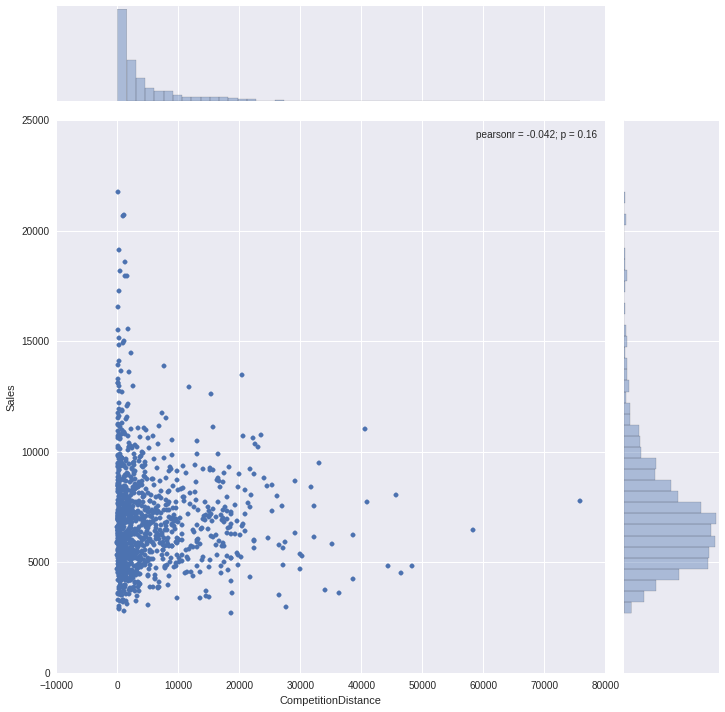

In [287]:
sns.jointplot(x='CompetitionDistance', y='Sales', data=train[train.CompetitionDistance != 0].groupby('Store').mean(), size=10);

## Train XGBoost and predict sales 

### 0. Cross Validation 

In [195]:
from sklearn.cross_validation import train_test_split
xtrain = train[train.Sales != 0][features]
ytrain = train[train.Sales != 0].Sales
x_tr, x_cv, y_tr, y_cv = train_test_split(xtrain, ytrain, test_size = 0.05,  random_state = 42)

In [229]:
x_tr = train.loc[(train.Sales != 0) & (train.Date < np.datetime64('2015-06-01T00:00:00.000000000+0000'))]
x_cv = train.loc[(train.Sales != 0) & (train.Date >= np.datetime64('2015-06-01T00:00:00.000000000+0000'))]
y_tr = x_tr.Sales
y_cv = x_cv.Sales
x_tr = x_tr[features]
x_cv = x_cv[features]

In [196]:
# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [218]:
%%time
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=10, n_jobs=3, random_state=42, oob_score=True)
clf.fit(x_tr, y_tr)
pred_RF = clf.predict(x_cv)

CPU times: user 3min 29s, sys: 1.25 s, total: 3min 30s
Wall time: 1min 29s


In [217]:
rmspe(y_cv, pred_RF)

0.12859339047224744

Feature ranking:


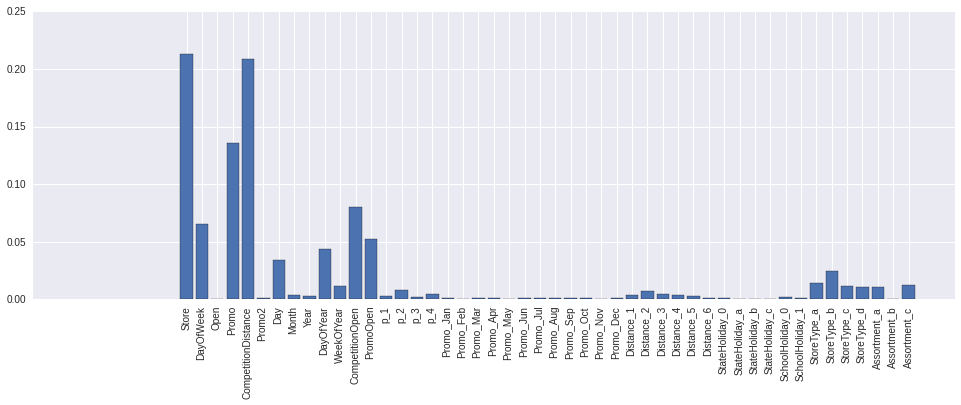

In [200]:
# Show feature importances
import pylab
import scipy

importances = clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

labels = [features[i] for i in indices.tolist()]
x = scipy.array(indices)
y = scipy.array(importances[indices])
f = pylab.figure(figsize=(16,5))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, y, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
f.show()

### 1. Check XGB score 

In [139]:
# Set params

params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": 0.2,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300
stop = 20

In [203]:
dtrain = xgb.DMatrix(x_tr.values, np.log(y_tr + 1))
dvalid = xgb.DMatrix(x_cv.values, np.log(y_cv + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=stop, feval=rmspe_xg, verbose_eval=True)

Will train until train error hasn't decreased in 20 rounds.
[0]	eval-rmspe:0.998703	train-rmspe:0.998706
[1]	eval-rmspe:0.994692	train-rmspe:0.994707
[2]	eval-rmspe:0.984477	train-rmspe:0.984519
[3]	eval-rmspe:0.963981	train-rmspe:0.964073
[4]	eval-rmspe:0.929669	train-rmspe:0.929785
[5]	eval-rmspe:0.880163	train-rmspe:0.880290
[6]	eval-rmspe:0.816942	train-rmspe:0.817082
[7]	eval-rmspe:0.743612	train-rmspe:0.743705
[8]	eval-rmspe:0.665579	train-rmspe:0.665582
[9]	eval-rmspe:0.588589	train-rmspe:0.588430
[10]	eval-rmspe:0.516435	train-rmspe:0.516249
[11]	eval-rmspe:0.453389	train-rmspe:0.452934
[12]	eval-rmspe:0.401050	train-rmspe:0.400209
[13]	eval-rmspe:0.359406	train-rmspe:0.358302
[14]	eval-rmspe:0.330699	train-rmspe:0.328325
[15]	eval-rmspe:0.309726	train-rmspe:0.307296
[16]	eval-rmspe:0.297693	train-rmspe:0.294705
[17]	eval-rmspe:0.283630	train-rmspe:0.280310
[18]	eval-rmspe:0.279123	train-rmspe:0.276210
[19]	eval-rmspe:0.275750	train-rmspe:0.272872
[20]	eval-rmspe:0.274341	train

### 2. Prepare test data and predict 

In [154]:
#Make predictions on the test set
dtest = xgb.DMatrix(test[features].as_matrix())
XGB = gbm.predict(dtest)
indices = XGB < 0
XGB[indices] = 0

In [182]:
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(XGB) - 1})
submission.to_csv("submit.csv", index=False)